## Here is the amazing DL net that will distinguish between Jennifer Aniston in bikini and Borat in mankini

In [371]:
import os
import struct
import gzip
import random
import sys

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.normalization import BatchNormalization

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.utils import np_utils

from keras.optimizers import SGD


from skimage import io # to show the image
import glob, os # to read the files 

In [443]:
# check the images in the training set:
def plot_data(path, person, kind='train'):
    full_path = path + '/' + kind + '/' + person + '/' # in the folder of the person now 
    
    # go through the files in the folder and save them to the array
    
    pic_list = glob.glob('./' + full_path + '*.jpg')
    pic_num = len(pic_list)
    
    pic_total_size = 200*300*3 # 3 because of the RGB
    
    if (pic_num > 0):
        images = np.zeros([len(pic_list), pic_total_size]) # create the matrix
    
    # final image with training data  
    fig = plt.figure()    

    idx = 0
    image_id = 330
    for pic in pic_list:
        images[idx, :] = io.imread(pic).flatten();
        idx += 1
        image_id += 1
        if idx < 10: # show fitst 9 images
            plt.subplot(image_id)
            plt.subplot(image_id).axis('off')
            plt.imshow(io.imread(pic))


    plt.show()
    
    p = np.random.permutation(pic_num)

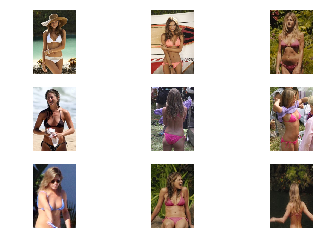

In [444]:
plot_data('data', 'j_resized') # show jennifer

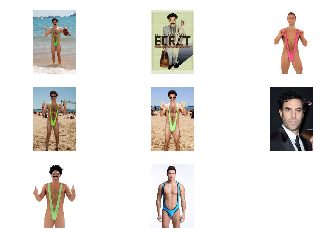

In [445]:
plot_data('data', 'b_resized') # show borat 

In [379]:
def load_data(path, person, kind='train'):
    full_path = path + '/' + kind + '/' + person + '/' # in the folder of the person now 
    
    # go through the files in the folder and save them to the array
    
    pic_list = glob.glob('./' + full_path + '*.jpg')
    pic_num = len(pic_list)
    
    pic_total_size = 200*300*3 # 3 because of the RGB
    
    if (pic_num > 0):
        images = np.zeros([len(pic_list), pic_total_size]) # create the matrix
        # print(images.shape)
        
    idx = 0
    for pic in pic_list:
        # print(pic)
        images[idx, :] = io.imread(pic).flatten();
        idx += 1
    
    p = np.random.permutation(pic_num)
    
    return images[p]
    

In [380]:
# read training data
# read jennifer
x_train_j = load_data('data', 'j_resized')
y_train_j = np.ones([x_train_j.shape[0], 1])
# read borat
x_train_b = load_data('data', 'b_resized')
y_train_b = np.ones([x_train_b.shape[0], 1])

train_num = x_train_j.shape[0] + x_train_b.shape[0]
perm = np.random.permutation(train_num)

x_train = np.vstack([x_train_j, x_train_b])[perm]
y_train = np.vstack([y_train_j, y_train_b])[perm]


In [449]:
# read test data
# read jennifer
x_test_j = load_data('data', 'j_resized', kind='test')
y_test_j = np.ones([x_test_j.shape[0], 1])
# read jennifer
x_test_b = load_data('data', 'b_resized', kind='test')
y_test_b = np.ones([x_test_b.shape[0], 1])

test_num = x_test_j.shape[0] + x_test_b.shape[0]
perm = np.random.permutation(test_num)

x_test = np.vstack([x_test_j, x_test_b])[perm]
y_test = np.vstack([y_test_j, y_test_b])[perm]

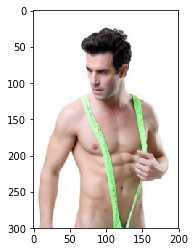

In [450]:
# test 
img = x_test[5, :]

plt.imshow(np.dstack((img[0::3].reshape([300,200]), 
                      img[1::3].reshape([300,200]), 
                      img[2::3].reshape([300,200]))).astype(np.uint8))

### Data Preparation

When dealing with images and convolutions, it is very important to handle `image_data_format` properly depending on the backend you are using:

In [451]:
img_rows, img_cols = 300, 200
img_channels = 3

if K.image_data_format() == 'channels_first':
    shape_ord = (img_channels, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, img_channels)

We now reshape the data and rescale it to be between 0 and 1:

In [452]:
x_train = x_train.reshape((x_train.shape[0],) + shape_ord)
x_test = x_test.reshape((x_test.shape[0],) + shape_ord)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

#### A simple CNN

Initializing the values for the convolution neural network:

In [453]:
nb_classes = 2
nb_epoch = 3  # kept very low! Please increase if you have GPU

batch_size = 5
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) # Day 3 about nestorov

Adjust the shapes (hot-vector conversion)

In [454]:
Y_train = keras.utils.to_categorical(y_train, num_classes=nb_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes=nb_classes)

print(x_train.shape, Y_train.shape)
print(x_test.shape, Y_test.shape)

(42, 300, 200, 3) (42, 2)
(9, 300, 200, 3) (9, 2)


In [460]:
def build_model():
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    # model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(x_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(x_test, Y_test))
          

    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(x_test, Y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    
#     for i, layer in enumerate(model.layers):
#         if len(layer.get_weights()) > 0:
#             W = layer.get_weights()
#             print("Layer", i, "\t", layer.name, "\t\t", W)

In [ ]:
%timeit -n1 -r1 build_model()

Train on 42 samples, validate on 9 samples
Epoch 1/3
42/42 [==============================] - 12s - loss: 0.2631 - acc: 1.0000 - val_loss: 9.7355e-07 - val_acc: 1.0000
Epoch 2/3
42/42 [==============================] - 12s - loss: 0.0042 - acc: 1.0000 - val_loss: 2.1193e-07 - val_acc: 1.0000

In [457]:
print('Available Metrics in Model: {}'.format(model.metrics_names))

Available Metrics in Model: ['loss', 'acc']


In [458]:
loss, accuracy = model.evaluate(x_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 1.19209289551e-07
Test Accuracy: 1.0


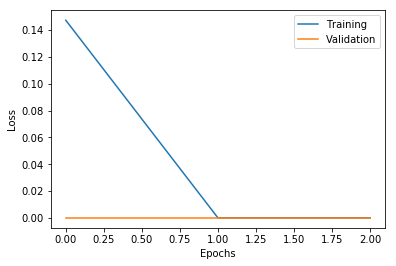

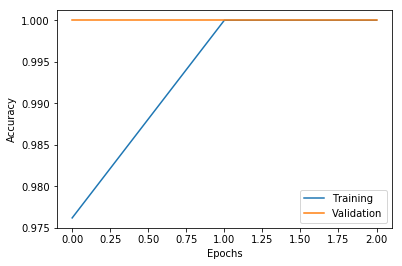

In [459]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')